In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv
/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_96590.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_32366.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_99675.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_85937.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_73903.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5/img_68208.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5/img_77583.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5/img_49189.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5/img_6690.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5/img_95740.jpg
/kaggle/input/state-farm-distracted-driver-detection/imgs/trai

In [7]:
train = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
train

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [8]:
train['path'] = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train/'+train['classname']+'/'+train['img']
train

,subject,classname,img,path
0,p002,c0,img_44733.jpg,/kaggle/input/state-farm-distracted-driver-det...
1,p002,c0,img_72999.jpg,/kaggle/input/state-farm-distracted-driver-det...
2,p002,c0,img_25094.jpg,/kaggle/input/state-farm-distracted-driver-det...
3,p002,c0,img_69092.jpg,/kaggle/input/state-farm-distracted-driver-det...
4,p002,c0,img_92629.jpg,/kaggle/input/state-farm-distracted-driver-det...
...,...,...,...,...
22419,p081,c9,img_56936.jpg,/kaggle/input/state-farm-distracted-driver-det...
22420,p081,c9,img_46218.jpg,/kaggle/input/state-farm-distracted-driver-det...
22421,p081,c9,img_25946.jpg,/kaggle/input/state-farm-distracted-driver-det...
22422,p081,c9,img_67850.jpg,/kaggle/input/state-farm-distracted-driver-det...


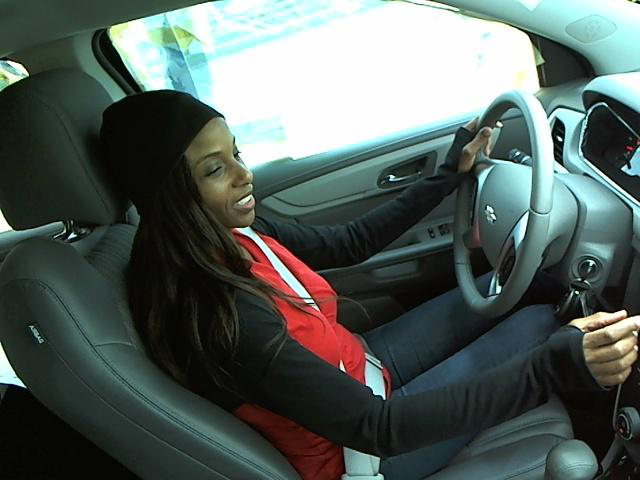

In [9]:
from PIL import Image
Image.open('/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5/img_68208.jpg')

In [10]:
import glob
test = pd.DataFrame({'path':glob.glob("/kaggle/input/state-farm-distracted-driver-detection/imgs/test/*")})
test

,path
0,/kaggle/input/state-farm-distracted-driver-det...
1,/kaggle/input/state-farm-distracted-driver-det...
2,/kaggle/input/state-farm-distracted-driver-det...
3,/kaggle/input/state-farm-distracted-driver-det...
4,/kaggle/input/state-farm-distracted-driver-det...
...,...
79721,/kaggle/input/state-farm-distracted-driver-det...
79722,/kaggle/input/state-farm-distracted-driver-det...
79723,/kaggle/input/state-farm-distracted-driver-det...
79724,/kaggle/input/state-farm-distracted-driver-det...


In [11]:
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from keras import *
from keras.layers import *
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from keras.callbacks import *

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

result = 0

# 모델선언 반드시 for문 내에서!!
for train_index, valid_index in skf.split(train, train['classname']):
    x_train = train.iloc[train_index]
    x_valid = train.iloc[valid_index]
    
    idg = ImageDataGenerator(horizontal_flip=True) # 데이터증식 : 1)이미지좌우반전, 학습용
    idg2 = ImageDataGenerator() # 테스트용
    idg3 = ImageDataGenerator() # 검증용
    
    train_generator = idg.flow_from_dataframe(x_train, x_col='path', y_col='classname', target_size=(300,300), batch_size=32)
    valid_generator = idg3.flow_from_dataframe(x_valid, x_col='path', y_col='classname', target_size=(300,300), batch_size=32)
    
    model = Sequential()
    
    model.add(EfficientNetB0(weights='imagenet', include_top=False, pooling='avg'))
    model.add(Dense(10,activation='softmax'))
    
    es = EarlyStopping(patience=3, verbose=1) # 점수가 점점 안좋아지면 2번까지 참고 일찍 학습 종료
    mc = ModelCheckpoint('best.h5', save_best_only=True, verbose=1) # 최적의 순간을 저장, 학습한 것 중 제일 성능 좋은 것만 저장하자!!
    rl = ReduceLROnPlateau(patience=2, verbose=1)
    
    model.compile(metrics=['acc'], loss='categorical_crossentropy', optimizer='adam')
    model.fit(train_generator, validation_data = valid_generator, epochs=5, callbacks=[es,mc,rl]) # epochs 학습횟수 지정, 기본은 1
    model.load_weights('best.h5')
    
    test_generator = idg2.flow_from_dataframe(test, x_col='path', y_col=None, 
                                          target_size=(300,300), batch_size=32, 
                                          class_mode=None, shuffle=False)
    
    result += model.predict(test_generator, verbose=1)/5

Found 17939 validated image filenames belonging to 10 classes.
Found 4485 validated image filenames belonging to 10 classes.
16711680/16705208 [==============================] - 0s 0us/step
Epoch 1/5
561/561 [==============================] - 340s 585ms/step - loss: 0.4240 - acc: 0.8697 - val_loss: 0.1168 - val_acc: 0.9721

Epoch 00001: val_loss improved from inf to 0.11683, saving model to best.h5
Epoch 2/5
561/561 [==============================] - 246s 438ms/step - loss: 0.0599 - acc: 0.9819 - val_loss: 0.0334 - val_acc: 0.9891

Epoch 00002: val_loss improved from 0.11683 to 0.03342, saving model to best.h5
Epoch 3/5
561/561 [==============================] - 246s 439ms/step - loss: 0.0380 - acc: 0.9882 - val_loss: 0.0820 - val_acc: 0.9764

Epoch 00003: val_loss did not improve from 0.03342
Epoch 4/5
561/561 [==============================] - 243s 434ms/step - loss: 0.0310 - acc: 0.9916 - val_loss: 0.0449 - val_acc: 0.9891

Epoch 00004: val_loss did not improve from 0.03342

Epoch 0

In [12]:
result

array([[7.2589428e-09, 9.8170050e-09, 2.3200965e-07, ..., 3.3474077e-08,
        9.9937904e-01, 3.9332012e-06],
       [5.4073768e-10, 2.8150119e-08, 5.1641106e-08, ..., 5.3685537e-04,
        5.1555219e-08, 1.1099673e-07],
       [8.8059696e-06, 1.4498702e-04, 2.4919184e-03, ..., 1.2702401e-05,
        1.1529298e-01, 3.0832234e-04],
       ...,
       [7.4450055e-04, 2.4640289e-04, 3.6014799e-06, ..., 9.1103075e-06,
        6.6016786e-05, 4.9534924e-03],
       [2.1010734e-07, 7.0817379e-07, 2.7540627e-06, ..., 1.6422807e-04,
        1.6926441e-04, 9.8390501e-06],
       [1.1209526e-06, 8.4692128e-06, 1.2618896e-04, ..., 1.5159523e-05,
        9.9717486e-01, 2.2869003e-03]], dtype=float32)

In [14]:
sub = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv')
display(test,sub)

,path
0,/kaggle/input/state-farm-distracted-driver-det...
1,/kaggle/input/state-farm-distracted-driver-det...
2,/kaggle/input/state-farm-distracted-driver-det...
3,/kaggle/input/state-farm-distracted-driver-det...
4,/kaggle/input/state-farm-distracted-driver-det...
...,...
79721,/kaggle/input/state-farm-distracted-driver-det...
79722,/kaggle/input/state-farm-distracted-driver-det...
79723,/kaggle/input/state-farm-distracted-driver-det...
79724,/kaggle/input/state-farm-distracted-driver-det...


,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_99994.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79722,img_99995.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79723,img_99996.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79724,img_99998.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [24]:
sub['img']=test['path'].apply(lambda x : x.split('/')[-1])
sub

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_96590.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_32366.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_99675.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_85937.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_73903.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_109.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79722,img_53257.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79723,img_90376.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79724,img_28000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [41]:
result2 = pd.DataFrame(data=result)
result2

,0,1,2,3,4,5,6,7,8,9
0,7.258943e-09,9.817005e-09,2.320097e-07,2.480176e-06,2.480907e-08,7.078402e-07,6.135707e-04,3.347408e-08,9.993790e-01,3.933201e-06
1,5.407377e-10,2.815012e-08,5.164111e-08,1.760925e-07,9.947687e-09,9.994622e-01,5.207550e-07,5.368554e-04,5.155522e-08,1.109967e-07
2,8.805970e-06,1.449870e-04,2.491918e-03,1.114354e-06,2.975193e-06,1.163466e-05,8.817246e-01,1.270240e-05,1.152930e-01,3.083223e-04
3,5.921766e-05,9.550498e-06,1.936084e-05,2.622626e-02,4.315324e-03,7.339368e-01,2.062341e-05,3.849767e-06,1.440290e-02,2.210061e-01
4,4.641591e-10,1.818860e-09,2.958035e-06,4.491636e-09,1.889179e-07,1.463715e-10,3.382882e-09,9.999968e-01,6.782203e-09,4.838508e-10
...,...,...,...,...,...,...,...,...,...,...
79721,5.858646e-10,3.316000e-08,9.999957e-01,8.089135e-09,1.667377e-07,4.963381e-09,2.900581e-07,2.313770e-10,3.642112e-06,1.371446e-07
79722,4.177332e-07,2.739136e-08,2.774033e-08,9.999962e-01,3.019284e-06,8.677850e-08,6.543927e-08,6.495893e-10,1.416431e-08,1.754635e-07
79723,7.445005e-04,2.464029e-04,3.601480e-06,9.923761e-01,1.542928e-03,4.306088e-05,1.476150e-05,9.110307e-06,6.601679e-05,4.953492e-03
79724,2.101073e-07,7.081738e-07,2.754063e-06,9.437156e-07,4.602931e-07,9.996433e-01,8.281476e-06,1.642281e-04,1.692644e-04,9.839050e-06


In [44]:
for i in range(0,10):    
    sub[f'c{i}'] = result2[i]
sub

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_96590.jpg,7.258943e-09,9.817005e-09,2.320097e-07,2.480176e-06,2.480907e-08,7.078402e-07,6.135707e-04,3.347408e-08,9.993790e-01,3.933201e-06
1,img_32366.jpg,5.407377e-10,2.815012e-08,5.164111e-08,1.760925e-07,9.947687e-09,9.994622e-01,5.207550e-07,5.368554e-04,5.155522e-08,1.109967e-07
2,img_99675.jpg,8.805970e-06,1.449870e-04,2.491918e-03,1.114354e-06,2.975193e-06,1.163466e-05,8.817246e-01,1.270240e-05,1.152930e-01,3.083223e-04
3,img_85937.jpg,5.921766e-05,9.550498e-06,1.936084e-05,2.622626e-02,4.315324e-03,7.339368e-01,2.062341e-05,3.849767e-06,1.440290e-02,2.210061e-01
4,img_73903.jpg,4.641591e-10,1.818860e-09,2.958035e-06,4.491636e-09,1.889179e-07,1.463715e-10,3.382882e-09,9.999968e-01,6.782203e-09,4.838508e-10
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_109.jpg,5.858646e-10,3.316000e-08,9.999957e-01,8.089135e-09,1.667377e-07,4.963381e-09,2.900581e-07,2.313770e-10,3.642112e-06,1.371446e-07
79722,img_53257.jpg,4.177332e-07,2.739136e-08,2.774033e-08,9.999962e-01,3.019284e-06,8.677850e-08,6.543927e-08,6.495893e-10,1.416431e-08,1.754635e-07
79723,img_90376.jpg,7.445005e-04,2.464029e-04,3.601480e-06,9.923761e-01,1.542928e-03,4.306088e-05,1.476150e-05,9.110307e-06,6.601679e-05,4.953492e-03
79724,img_28000.jpg,2.101073e-07,7.081738e-07,2.754063e-06,9.437156e-07,4.602931e-07,9.996433e-01,8.281476e-06,1.642281e-04,1.692644e-04,9.839050e-06


In [45]:
sub.to_csv('sub.csv',index=0)